In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
import joblib


In [7]:
# Load data
df = pd.read_csv(
    "training.1600000.processed.noemoticon.csv",
    encoding='latin-1',
    header=None,
    on_bad_lines='skip'  # Skips problematic lines
)

# Assign column names
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Sample data
df = df.sample(n=800000, random_state=42).reset_index(drop=True)


In [8]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)     # remove mentions
    text = re.sub(r"#\w+", "", text)     # remove hashtags
    text = re.sub(r"[^A-Za-z\s]", "", text)  # remove special chars
    text = text.lower()
    return text.strip()

df["clean_text"] = df["text"].apply(clean_text)

# Convert target: 0 = negative, 4 = positive → 0 = negative, 1 = positive
df["sentiment"] = df["target"].apply(lambda x: 0 if x == 0 else 1)


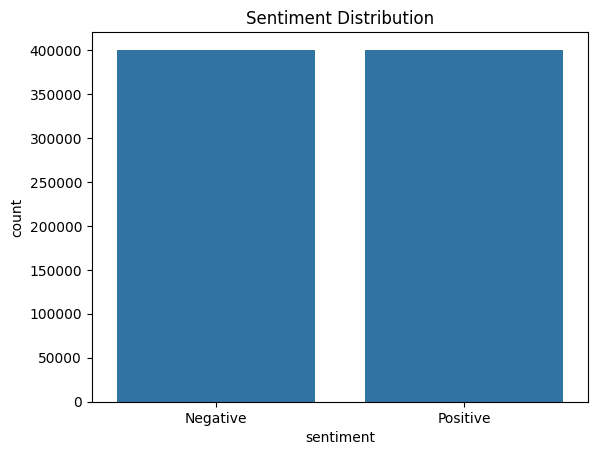

In [9]:
sns.countplot(data=df, x="sentiment")
plt.title("Sentiment Distribution")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()


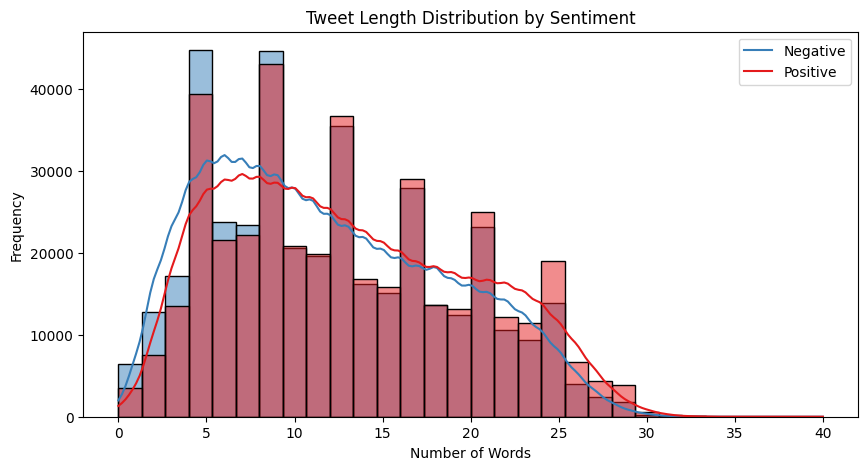

In [10]:
df["text_length"] = df["clean_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(data=df, x="text_length", hue="sentiment", bins=30, kde=True, palette="Set1")
plt.title("Tweet Length Distribution by Sentiment")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend(labels=["Negative", "Positive"])
plt.show()


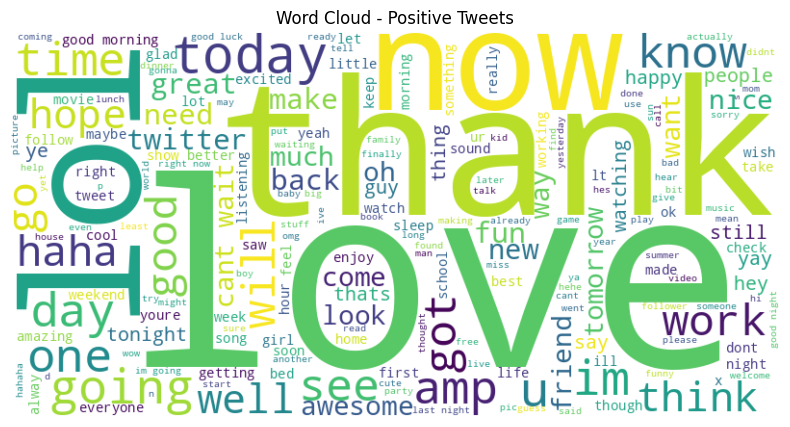

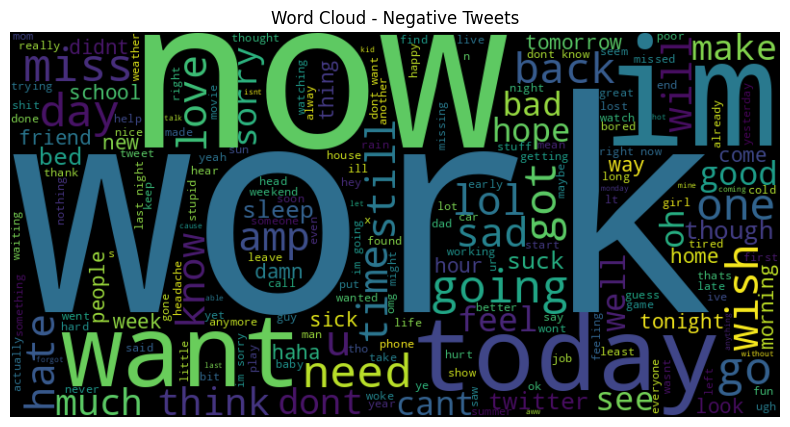

In [11]:
from collections import Counter
from wordcloud import WordCloud

# Separate datasets
pos_texts = df[df["sentiment"] == 1]["clean_text"]
neg_texts = df[df["sentiment"] == 0]["clean_text"]

def plot_wordcloud(text_series, title, color="white"):
    text = " ".join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color=color).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud(pos_texts, "Word Cloud - Positive Tweets", color="white")
plot_wordcloud(neg_texts, "Word Cloud - Negative Tweets", color="black")


In [12]:
X = df["clean_text"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
tfidf = TfidfVectorizer(max_features=50000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)


In [15]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVC": LinearSVC()
}

results = {}

for name, model in models.items():
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"--- {name} ---")
    print(classification_report(y_test, preds))


--- Naive Bayes ---
              precision    recall  f1-score   support

           0       0.76      0.79      0.78     79976
           1       0.78      0.76      0.77     80024

    accuracy                           0.77    160000
   macro avg       0.77      0.77      0.77    160000
weighted avg       0.77      0.77      0.77    160000

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.80      0.79      0.79     79976
           1       0.79      0.81      0.80     80024

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000

--- Linear SVC ---
              precision    recall  f1-score   support

           0       0.79      0.78      0.79     79976
           1       0.79      0.80      0.79     80024

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighte

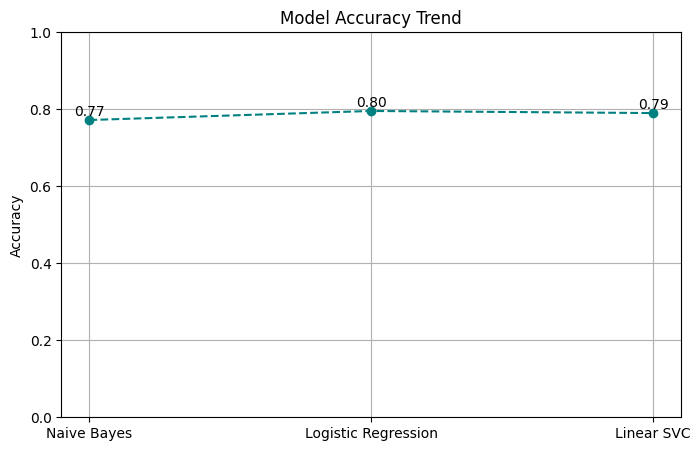

In [16]:
plt.figure(figsize=(8,5))
plt.plot(list(results.keys()), list(results.values()), marker='o', linestyle='--', color='teal')
plt.title("Model Accuracy Trend")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, val in enumerate(results.values()):
    plt.text(i, val + 0.01, f"{val:.2f}", ha='center')
plt.grid(True)
plt.show()
best_model_name = max(results, key=results.get)

In [17]:
best_model = models[best_model_name]
joblib.dump(best_model, "best_sentiment_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']